In [1]:
from transformers import ( 
    HubertModel, 
    HubertForCTC, 
    HubertForSequenceClassification,
    Wav2Vec2FeatureExtractor
)
import torch
import librosa

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import simpsom as sps
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import adjusted_rand_score, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

## Загрузка данных

In [2]:
df_train = pd.read_csv('../crowd_train.csv')
df_train.head()

,id,audio_path,features_path,emotion
0,475e76f77ac1ed7cabafca740b15b32a,data/crowd/crowd_train/wavs/475e76f77ac1ed7cab...,data/features/475e76f77ac1ed7cabafca740b15b32a...,angry
1,2f9438ef68395c70a8714dc373a49d11,data/crowd/crowd_train/wavs/2f9438ef68395c70a8...,data/features/2f9438ef68395c70a8714dc373a49d11...,neutral
2,fb0ae78586a235018103acec22a80a8f,data/crowd/crowd_train/wavs/fb0ae78586a2350181...,data/features/fb0ae78586a235018103acec22a80a8f...,neutral
3,196dcf9e1aaac46c2aee45e7f6adfb92,data/crowd/crowd_train/wavs/196dcf9e1aaac46c2a...,data/features/196dcf9e1aaac46c2aee45e7f6adfb92...,neutral
4,41d7f48ca93b01e4a01a4f34b40a69ff,data/crowd/crowd_train/wavs/41d7f48ca93b01e4a0...,data/features/41d7f48ca93b01e4a01a4f34b40a69ff...,neutral


In [3]:
df_train[['emotion']].groupby('emotion').value_counts()

emotion
angry       29798
neutral     74872
positive    22007
sad         56378
Name: count, dtype: int64

In [3]:
df_test = pd.read_csv('../crowd_test.csv')
df_test.head()

,id,audio_path,features_path,emotion
0,9e9961c53ca6eeb440b217e539fbf46c,data/crowd/crowd_test/wavs/9e9961c53ca6eeb440b...,data/features/9e9961c53ca6eeb440b217e539fbf46c...,neutral
1,0166f65a30354db8282682b1a280e64c,data/crowd/crowd_test/wavs/0166f65a30354db8282...,data/features/0166f65a30354db8282682b1a280e64c...,neutral
2,d49a6b560155831725a7bdc7d0a96099,data/crowd/crowd_test/wavs/d49a6b560155831725a...,data/features/d49a6b560155831725a7bdc7d0a96099...,neutral
3,c6852b0925797612d7b6724da8cbe7b4,data/crowd/crowd_test/wavs/c6852b0925797612d7b...,data/features/c6852b0925797612d7b6724da8cbe7b4...,neutral
4,64a7aa17132c3e4b7be1aaed5fc88090,data/crowd/crowd_test/wavs/64a7aa17132c3e4b7be...,data/features/64a7aa17132c3e4b7be1aaed5fc88090...,positive


In [23]:
df_test['emotion'].value_counts()

emotion
neutral     7462
sad         4623
angry       2853
positive    2279
Name: count, dtype: int64

## Общие методы

In [4]:
# Получение выхода с модели
def get_output_for_audio(audio, feature_extractor, model, sampling_rate=16000):
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]
    
    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)

    return output

In [5]:
def emotion_to_num(emo):
    e2n = {'positive': 0, 'sad': 1, 'angry': 2, 'neutral': 3}
    return e2n[emo]

In [6]:
# Получение массива со значениями признаков
def get_features_and_labels_array(df, model, feature_extractor, layer_number, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.hidden_states[layer_number].detach().numpy()[0]
    features_list = [hidden_state]
    labels_list = [[emotion_to_num(df['emotion'][0]) for _ in range(hidden_state.shape[0])]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.hidden_states[layer_number].detach().numpy()[0]
        features_list.append(hidden_state)
        labels_list.append([emotion_to_num(row['emotion']) for _ in range(hidden_state.shape[0])])
    
    data = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    return data, labels

## I. Бинарная классификация и кластеризация

In [7]:
n_samples = 1000
df_train_part = df_train.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_bin_train = df_train_part[df_train_part['emotion'].isin(['positive', 'sad'])].reset_index(drop=True)
df_bin_train[['emotion']].groupby('emotion').value_counts()

emotion
positive    1000
sad         1000
Name: count, dtype: int64

In [8]:
n_samples = 500
df_test_part = df_test.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_bin_test = df_test_part[df_test_part['emotion'].isin(['positive', 'sad'])].reset_index(drop=True)
df_bin_test[['emotion']].groupby('emotion').value_counts()

emotion
positive    500
sad         500
Name: count, dtype: int64

### 1. Признаки с модели Hubert-large

In [4]:
model_name = "facebook/hubert-large-ll60k"
model = HubertModel.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)

Some weights of the model checkpoint at facebook/hubert-large-ll60k were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-large-ll60k and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for p

In [97]:
X_train, y_train = get_features_and_labels_array(df_bin_train, model, feature_extractor, 0)

In [98]:
print(X_train.shape)
print(y_train.shape)

(506752, 1024)
(506752,)


In [99]:
X_test, y_test = get_features_and_labels_array(df_bin_test, model, feature_extractor, 0)

In [100]:
print(X_test.shape)
print(y_test.shape)

(249862, 1024)
(249862,)


In [101]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
y_pred = kn_clf.predict(X_test)
kn_accuracy = accuracy_score(y_test, y_pred)
print(kn_accuracy)

0.5636591398451946


In [110]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(X_train)
k_means_labels = k_means.predict(X_test)
print(f'KMeans rand score: {adjusted_rand_score(y_test, k_means_labels)}')

C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans rand score: -5.3844321548584784e-05


In [111]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X_train)
gmm_labels = gmm.predict(X_test)
print(f'GMM rand score: {adjusted_rand_score(y_test, gmm_labels)}')

GMM rand score: 8.740995239387068e-05


2024-12-14 19:10:29.615 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-12-14 19:10:29.617 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-12-14 19:10:29.655 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-12-14 19:10:30.521 | INFO     | simpsom.network:train:396 - Early stop active.
2024-12-14 19:10:30.521 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
2024-12-14 19:11:42.417 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


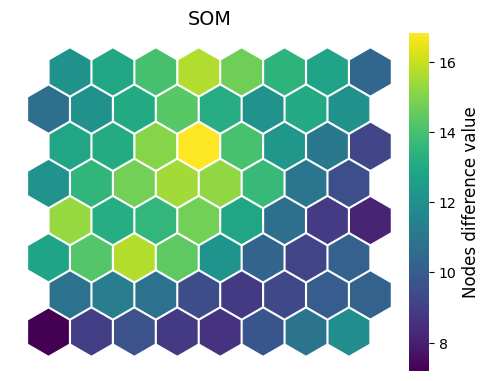

2024-12-14 19:11:59.800 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-12-14 19:12:14.683 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


SOM rand score: 0.0023111848861545863


In [113]:
som = sps.SOMNet(8, 8, X_train, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=True, CUML=False,
                 debug=False)

som.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som.plot_map_by_difference(show=True, print_out=False)

som_labels, _ = som.cluster(X_test, algorithm='KMeans', n_clusters=2)
print(f'SOM rand score: {adjusted_rand_score(y_test, som_labels)}')

In [114]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

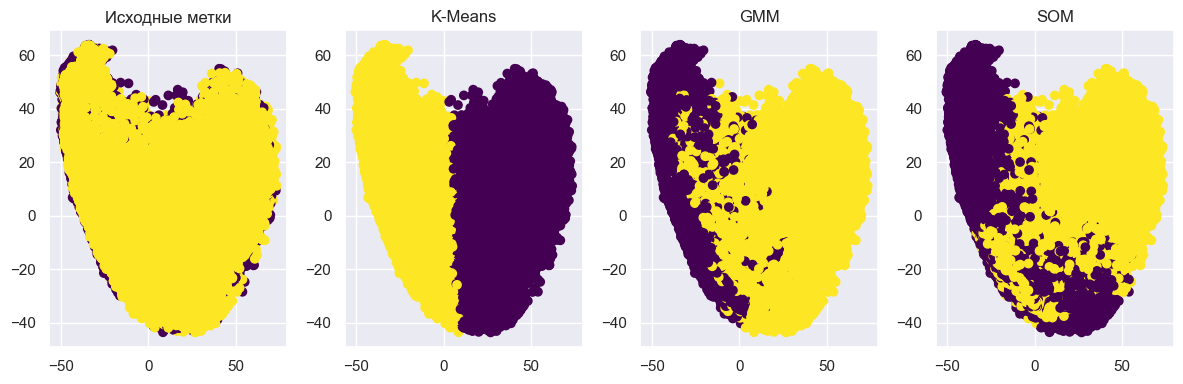

In [116]:
sns.set()

fig, axs = plt.subplots(1, 4)
fig.set_figheight(4)
fig.set_figwidth(12)

axs[0].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=y_test, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=gmm_labels, cmap='viridis')
axs[2].set_title('GMM')

axs[3].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=som_labels, cmap='viridis')
axs[3].set_title('SOM')

plt.tight_layout()
plt.show()

### 2. Признаки с дообученной модели Hubert-large

In [9]:
model_name = "xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned"
model = HubertForSequenceClassification.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")

Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

In [10]:
X_train, y_train = get_features_and_labels_array(df_bin_train, model, feature_extractor, -1)
X_test, y_test = get_features_and_labels_array(df_bin_test, model, feature_extractor, -1)

In [119]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(506752, 1024)
(506752,)
(249862, 1024)
(249862,)


In [120]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
y_pred = kn_clf.predict(X_test)
kn_accuracy = accuracy_score(y_test, y_pred)
print(kn_accuracy)

0.8252835565232008


In [121]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(X_train)
k_means_labels = k_means.predict(X_test)
print(f'KMeans rand score: {adjusted_rand_score(y_test, k_means_labels)}')

C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans rand score: 0.5288629233717927


In [11]:
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X_train)
gmm_labels = gmm.predict(X_test)
print(f'GMM rand score: {adjusted_rand_score(y_test, gmm_labels)}')

GMM rand score: 0.09443457175537714


In [15]:
lgmm_labels

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

2024-12-14 22:52:07.699 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-12-14 22:52:07.700 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-12-14 22:52:07.745 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-12-14 22:52:07.746 | INFO     | simpsom.network:train:396 - Early stop active.
2024-12-14 22:52:07.748 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
2024-12-14 22:53:26.137 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


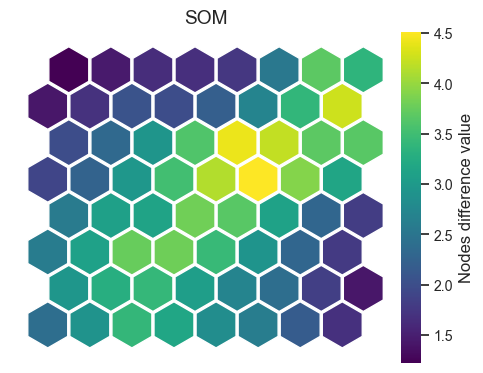

2024-12-14 22:53:43.387 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-12-14 22:54:00.163 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


SOM rand score: 0.3611372873663651


In [143]:
som = sps.SOMNet(8, 8, X_train, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=True, CUML=False,
                 debug=False)

som.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som.plot_map_by_difference(show=True, print_out=False)

som_labels, _ = som.cluster(X_test, algorithm='KMeans', n_clusters=2)
print(f'SOM rand score: {adjusted_rand_score(y_test, som_labels)}')

In [125]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

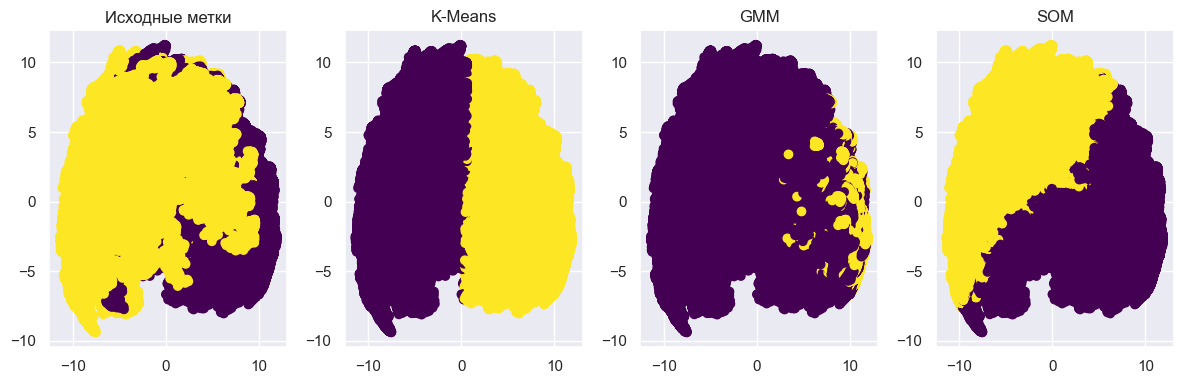

In [144]:
fig, axs = plt.subplots(1, 4)
fig.set_figheight(4)
fig.set_figwidth(12)

axs[0].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=y_test, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

axs[2].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=gmm_labels, cmap='viridis')
axs[2].set_title('GMM')

axs[3].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=som_labels, cmap='viridis')
axs[3].set_title('SOM')

plt.tight_layout()
plt.show()

## II. Классификация и кластеризация на полном наборе эмоций

In [7]:
n_samples = 1000
df_train_part = df_train.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_train_part[['emotion']].groupby('emotion').value_counts()

emotion
angry       1000
neutral     1000
positive    1000
sad         1000
Name: count, dtype: int64

In [8]:
n_samples = 500
df_test_part = df_test.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_test_part[['emotion']].groupby('emotion').value_counts()

emotion
angry       500
neutral     500
positive    500
sad         500
Name: count, dtype: int64

In [9]:
model_name = "xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned"
model = HubertForSequenceClassification.from_pretrained(
    model_name,
    output_hidden_states=True
)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-large-ls960-ft")

Some weights of the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned were not used when initializing HubertForSequenceClassification: ['hubert.encoder.pos_conv_embed.conv.weight_g', 'hubert.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at xbgoose/hubert-speech-emotion-recognition-russian-dusha-finetuned and are newly initialized: ['hubert.encoder.pos_conv_embed.conv.parametri

In [10]:
X_train, y_train = get_features_and_labels_array(df_train_part, model, feature_extractor, -1)
X_test, y_test = get_features_and_labels_array(df_test_part, model, feature_extractor, -1)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(967360, 1024)
(967360,)
(487319, 1024)
(487319,)


In [12]:
kn_clf = KNeighborsClassifier()
kn_clf.fit(X_train, y_train)
y_pred = kn_clf.predict(X_test)
kn_accuracy = accuracy_score(y_test, y_pred)
print(kn_accuracy)

0.6422487118294177


In [13]:
k_means = KMeans(n_clusters=4, random_state=0)
k_means.fit(X_train)
k_means_labels = k_means.predict(X_test)
print(f'KMeans rand score: {adjusted_rand_score(y_test, k_means_labels)}')

C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans rand score: 0.36952499882512546


2024-12-15 14:31:16.974 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-12-15 14:31:16.976 | INFO     | simpsom.network:_set_weights:191 - The weights will be initialized randomly.
2024-12-15 14:31:20.036 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.
2024-12-15 14:31:20.899 | INFO     | simpsom.network:train:396 - Early stop active.
2024-12-15 14:31:20.900 | WARNING  | simpsom.network:train:397 - Early stop is an experimental feature, make sure to know what you are doing!
2024-12-15 14:33:29.740 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


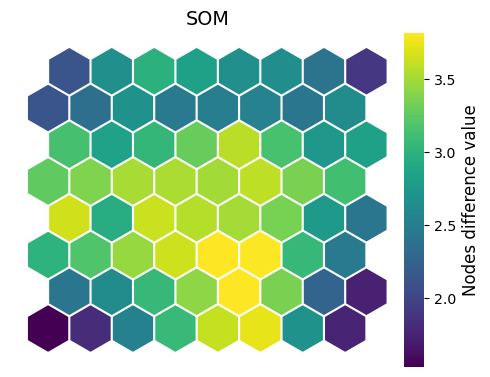

2024-12-15 14:34:05.939 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
./som_projected_KMeans.npy
C:\Study\clustering-methods\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
2024-12-15 14:34:39.319 | INFO     | simpsom.network:cluster:678 - Clustering results will be saved to:
././som_clusters.npy


SOM rand score: 0.3451817447214389


In [14]:
som = sps.SOMNet(8, 8, X_train, topology='hexagonal',
                 init='random', metric='euclidean',
                 neighborhood_fun='gaussian', PBC=False,
                 random_seed=32, GPU=True, CUML=False,
                 debug=False)

som.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=100,
          early_stop="mapdiff", early_stop_tolerance=1e-5)

som.plot_map_by_difference(show=True, print_out=False)

som_labels, _ = som.cluster(X_test, algorithm='KMeans', n_clusters=4)
print(f'SOM rand score: {adjusted_rand_score(y_test, som_labels)}')

In [ ]:
# gmm = GaussianMixture(n_components=4, random_state=0)
# gmm.fit(X_train)
# gmm_labels = gmm.predict(X_test)
# print(f'GMM rand score: {adjusted_rand_score(y_test, gmm_labels)}')

In [16]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

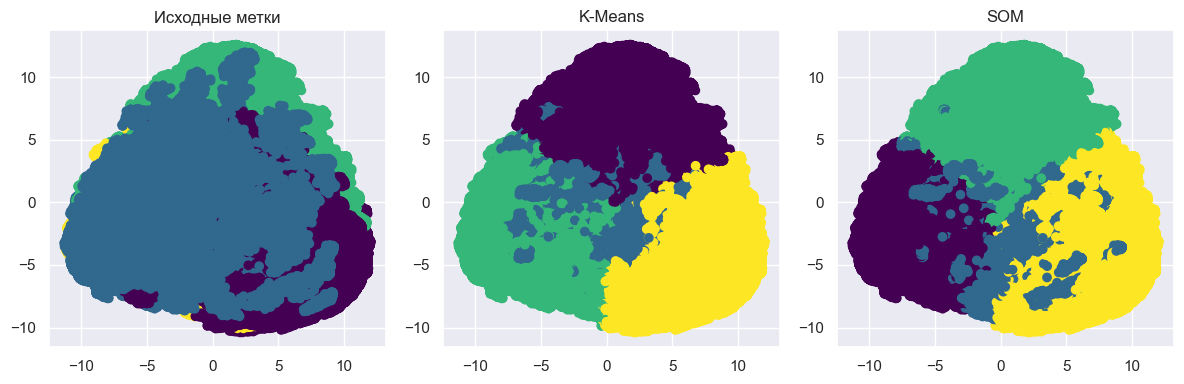

In [20]:
sns.set()

fig, axs = plt.subplots(1, 3)
fig.set_figheight(4)
fig.set_figwidth(12)

axs[0].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=y_test, cmap='viridis')
axs[0].set_title('Исходные метки')

axs[1].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=k_means_labels, cmap='viridis')
axs[1].set_title('K-Means')

# axs[2].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=gmm_labels, cmap='viridis')
# axs[2].set_title('GMM')

axs[2].scatter(x=X_test_pca[:, 0], y=X_test_pca[:, 1], c=som_labels, cmap='viridis')
axs[2].set_title('SOM')

plt.tight_layout()
plt.show()

In [22]:
hubert_k_means_results = []
for _, row in df_test_part.iterrows():
    output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, 16000)
    hidden_state = output.hidden_states[-1].detach().numpy()[0]
    labels = list(k_means.predict(hidden_state))
    n_samples = hidden_state.shape[0]
    counts = [
        labels.count(0),
        labels.count(1),
        labels.count(2),
        labels.count(3)
    ]
    
    hubert_k_means_results.append({
        "id": row["id"],
        "emotion": row["emotion"],
        "n_samples": n_samples,
        "0": counts[0] / n_samples,
        "1": counts[1] / n_samples,
        "2": counts[2] / n_samples,
        "3": counts[3] / n_samples,
        "most_freq_cluster": counts.index(max(counts))
    })

df_hubert_k_means = pd.DataFrame(hubert_k_means_results)

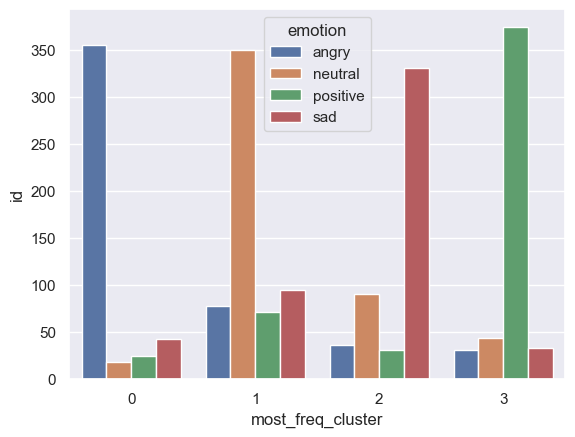

In [24]:
sns.barplot(x="most_freq_cluster",
            y="id",
            hue="emotion",
            data=df_hubert_k_means[['emotion', 'most_freq_cluster', "id"]].groupby(['emotion', 'most_freq_cluster']).nunique()
)
plt.show()